In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import math
import yfinance as yf
from scipy.optimize import minimize
import warnings

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


# GARCH(1,1) Correlation Estimation Project

## Project Overview
This project implements Maximum Likelihood Estimation (MLE) for the GARCH(1,1) model to estimate time-varying volatilities and correlations using daily stock returns. You will analyze real market data to understand volatility clustering and correlation dynamics.

## Learning Objectives
- Implement GARCH(1,1) model for volatility estimation
- Estimate time-varying correlations between financial assets
- Analyze correlation patterns and their implications for portfolio risk
- Compare correlation behavior across different market periods

## Task 1: Individual Volatility Estimation

**Requirements:**
- Download 3-year historical daily prices for AAPL and MSFT (2021-2024)
- Calculate daily returns and implement GARCH(1,1) model for each stock
- Estimate parameters: ω (omega), α (alpha), β (beta) using MLE
- Plot conditional volatilities over time
- **Analysis:** Compare volatility patterns and clustering effects between the two stocks

[*********************100%***********************]  2 of 2 completed

Task1 - GARCH(1,1) Volatility Estimation



GARCH(1,1) MLE Results — AAPL
omega  = 2.213979996085e-06
alpha  = 0.048035
beta   = 0.945994
Long-run sigma = 0.019254
Max log-likelihood = 5415.5647

GARCH(1,1) MLE Results — MSFT
omega  = 1.252700056820e-06
alpha  = 0.034464
beta   = 0.961034
Long-run sigma = 0.016681
Max log-likelihood = 5397.7630


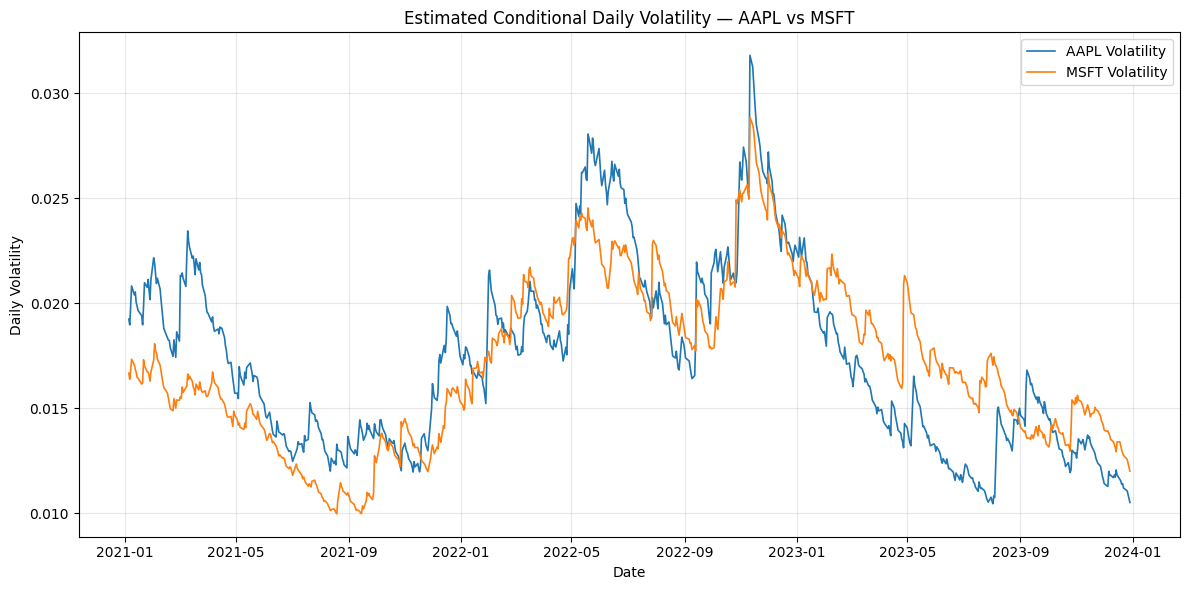

In [ ]:
print(f'=' * 60)
print(f'Task1 - GARCH(1,1) Volatility Estimation')
print(f'=' * 60)
# Your code here

# Data Download
df = yf.download(["AAPL", "MSFT"], start="2021-01-01", end="2023-12-31")
df_close = df['Close'].dropna()

# Daily Returns
df_return = df_close.pct_change().dropna()
df_dates = df_return.index

# GARCH(1,1) Function
def garch(x, u):
    omega, alpha, beta = x
    n = len(u)
    var = np.zeros(n)
    var[0] = max(1e-12, omega / max(1e-6, 1.0 - alpha - beta))
    for t in range(1, n):
        var[t] = omega + alpha * (u[t-1]**2) + beta * var[t-1]
    return np.clip(var, 1e-12, None)

# Maximum Likelihood Estimation Algorithm
def loglike(x, u):
    var = garch(x, u)
    return float(np.sum(np.log(var) + (u**2)/var))

# Optimization
def garch_opt(u):
    alpha0, beta0 = 0.05, 0.90
    omega0 = max(1e-12, (1 - alpha0 - beta0) * np.var(u, ddof=1))
    x0 = np.array([omega0, alpha0, beta0])

    res = minimize(
        fun=loglike,
        x0=x0,
        args=(u,),
        method="trust-constr",
        bounds=[(1e-12, None), (0.0, 0.999999), (0.0, 0.999999)],
        constraints=[{'type': 'ineq', 'fun': lambda x: 0.999999 - x[1] - x[2]}],
    )

    omega_hat, alpha_hat, beta_hat = res.x
    var_hat = garch((omega_hat, alpha_hat, beta_hat), u)
    return omega_hat, alpha_hat, beta_hat, var_hat, -res.fun

# MLE Results
results = {}
for col in df_return.columns:
    u = df_return[col].to_numpy()
    omega_hat, alpha_hat, beta_hat, var_hat, max_loglike = garch_opt(u)
    results[col] = {
        "omega": omega_hat,
        "alpha": alpha_hat,
        "beta": beta_hat,
        "sigma_L": np.sqrt(omega_hat / (1 - alpha_hat - beta_hat)),
        "var_hat": var_hat,
        "loglike": max_loglike
    }

    print(f"\nGARCH(1,1) MLE Results — {col}")
    print(f"omega  = {omega_hat:.12e}")
    print(f"alpha  = {alpha_hat:.6f}")
    print(f"beta   = {beta_hat:.6f}")
    print(f"Long-run sigma = {results[col]['sigma_L']:.6f}")
    print(f"Max log-likelihood = {max_loglike:.6f}")

# Visualization
plt.figure(figsize=(12, 6))
for col in df_return.columns:
    sigma_hat = np.sqrt(results[col]["var_hat"])
    plt.plot(df_dates, sigma_hat, label=f"{col} Volatility", lw=1.2)

plt.title("Estimated Conditional Daily Volatility — AAPL vs MSFT")
plt.xlabel("Date")
plt.ylabel("Daily Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

1. Clustering Effects
    - AAPL: α = 0.048035, β = 0.945994 → α + β = 0.994029
    - MSFT: α = 0.034464, β = 0.961034 → α + β = 0.995498\
Both stocks are highly persistent (α + β close to 1), meaning volatility shocks decay slowly, showing clear clustering.

2. Volatility Patterns
    - AAPL: σ = 1.9254 %
    - MSFT: σ = 1.6681 %
AAPL has a higher long-run volatility, suggesting slightly higher daily risk on average.\
This matches the plot, where AAPL’s volatility line generally lies above MSFT’s.

3. Volatility Behavior Over Time
Both stocks exhibit synchronized volatility spikes (early 2022 and late 2022).\
AAPL’s spikes are taller and more abrupt (larger α), while MSFT’s volatility decays more gradually (higher β), showing longer-lasting effects.

## Task 2: Dynamic Correlation Estimation

**Requirements:**
- Implement bivariate GARCH(1,1) model for correlation estimation
- Estimate time-varying correlation between AAPL and MSFT returns
- Plot correlation dynamics over the 3-year period
- **Analysis:** Discuss whether the stocks are positively/negatively correlated and how correlation changes over time

Task2 - GARCH(1,1) Correlation Estimation
Bivariate GARCH(1,1) MLE Results
omega  = 1.232343662574e-06
alpha  = 0.051419
beta   = 0.940146
Static Correlation = 0.722119
Average Dynamic Correlation = 0.650320


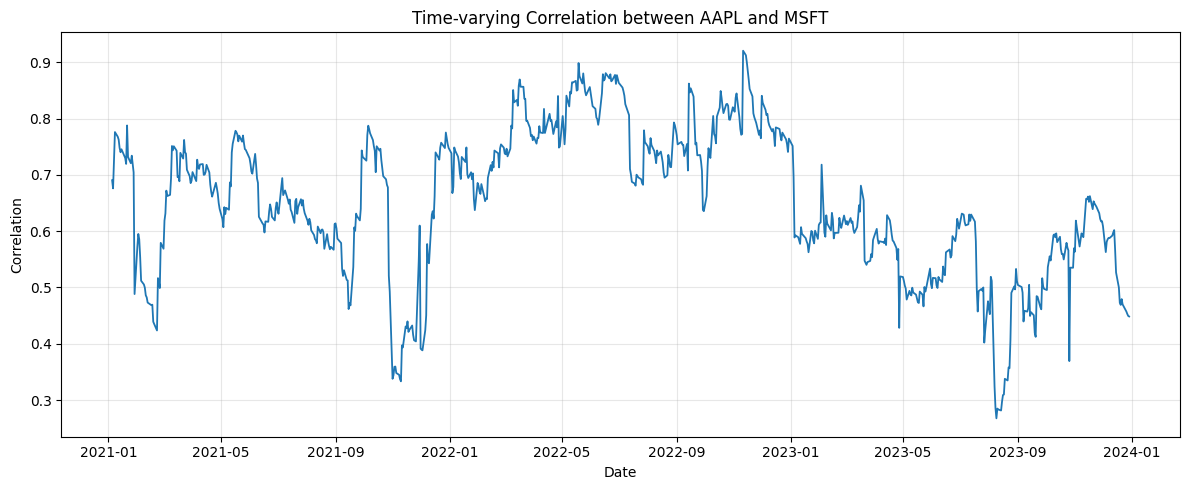

In [ ]:
print(f'=' * 60)
print(f'Task2 - GARCH(1,1) Correlation Estimation')
print(f'=' * 60)
# Your code here

# Extract returns and variances
x_return = df_return["AAPL"].to_numpy()
y_return = df_return["MSFT"].to_numpy()
x_var = results["AAPL"]["var_hat"]
y_var = results["MSFT"]["var_hat"]

# Bivariate GARCH(1,1) for Covariance
def garch_cov(x, x_return, y_return):
    omega, alpha, beta = x
    n = len(x_return)
    cov = np.zeros(n)
    cov[0] = np.cov(x_return, y_return, ddof=1)[0, 1]
    for t in range(1, n):
        cov[t] = omega + alpha * (x_return[t-1] * y_return[t-1]) + beta * cov[t-1]
    return cov

# Log-Likelihood for Bivariate GARCH(1,1)
def loglik_cov(x, x_return, y_return, x_var, y_var):
    cov = garch_cov(x, x_return, y_return)
    if np.any(x_var * y_var - cov**2 <= 0):
        return 1e12
    qf = (y_var * x_return**2
          - 2.0 * cov * x_return * y_return
          + x_var * y_return**2) / (x_var * y_var - cov**2)
    return float(np.sum(np.log(x_var * y_var - cov**2) + qf))

# Initial Parameters
alpha0, beta0 = 0.05, 0.93
omega0 = (1 - alpha0 - beta0) * np.cov(x_return, y_return, ddof=1)[0, 1]
x0 = np.array([omega0, alpha0, beta0])

# Optimization
res_cov = minimize(
    fun = loglik_cov,
    x0 = x0,
    args=(x_return, y_return, x_var, y_var),
    method="trust-constr",
    bounds=[(None, None), (0.0, 0.999999), (0.0, 0.999999)],
    constraints=[{'type': 'ineq', 'fun': lambda x: 0.999999 - x[1] - x[2]}]
)

# MLE Results
omega_c, alpha_c, beta_c = res_cov.x
cov = garch_cov((omega_c, alpha_c, beta_c), x_return, y_return)
corr = cov / np.sqrt(x_var * y_var)

print(f"Bivariate GARCH(1,1) MLE Results")
print(f"omega  = {omega_c:.12e}")
print(f"alpha  = {alpha_c:.6f}")
print(f"beta   = {beta_c:.6f}")
print(f"Static Correlation = {np.corrcoef(x_return, y_return)[0, 1]:.6f}")
print(f"Average Dynamic Correlation = {np.nanmean(corr):.6f}")

# Visualization
plt.figure(figsize=(12,5))
plt.plot(df_dates, corr, lw=1.3)
plt.title("Time-varying Correlation between AAPL and MSFT")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

1. Direction of Correlation
    - Both the static correlation (0.722119) and the average dynamic correlation (0.650320) are positive.
    - This indicates that AAPL and MSFT tend to move in the same direction most of the time: when one rises, the other usually rises as well.
2. Time-Varying Pattern
    - From the plot, the correlation fluctuates between roughly 0.3 and 0.9 during 2021–2023.
    - During market stress periods (early and late 2022), correlation spikes upward, showing that the two stocks move more closely together when market-wide factors dominate.
    - In calmer periods (2021 and 2023), correlation declines, suggesting more firm-specific behavior.
    - This pattern reflects a well-known fact: correlations rise in volatile markets and weaken in stable ones.

## Task 3: Negative Correlation Analysis

**Requirements:**
- Identify two stocks that exhibit negative correlation during specific market periods
- Suggested pairs: Tech vs. Utilities (e.g., AAPL vs. SO), or Growth vs. Value stocks
- Download data and estimate rolling correlations 
- Identify and highlight periods of negative correlation
- **Analysis:** Explain the economic rationale for negative correlation periods and their duration



[*********************100%***********************]  2 of 2 completed

Task 3 - Negative Correlation Analysis



GARCH(1,1) MLE Results — AAPL
omega  = 2.213979996085e-06
alpha  = 0.048035
beta   = 0.945994
Long-run sigma = 0.019254
Max log-likelihood = 5415.564688

GARCH(1,1) MLE Results — MSFT
omega  = 1.252700056820e-06
alpha  = 0.034464
beta   = 0.961034
Long-run sigma = 0.016681
Max log-likelihood = 5397.763032

Bivariate GARCH(1,1) MLE Results — AAPL – SO
omega  = 4.335120622625e-06
alpha  = 0.051680
beta   = 0.845175

Static Correlation (AAPL, SO) = 0.274377
Average Dynamic Correlation   = 0.218239


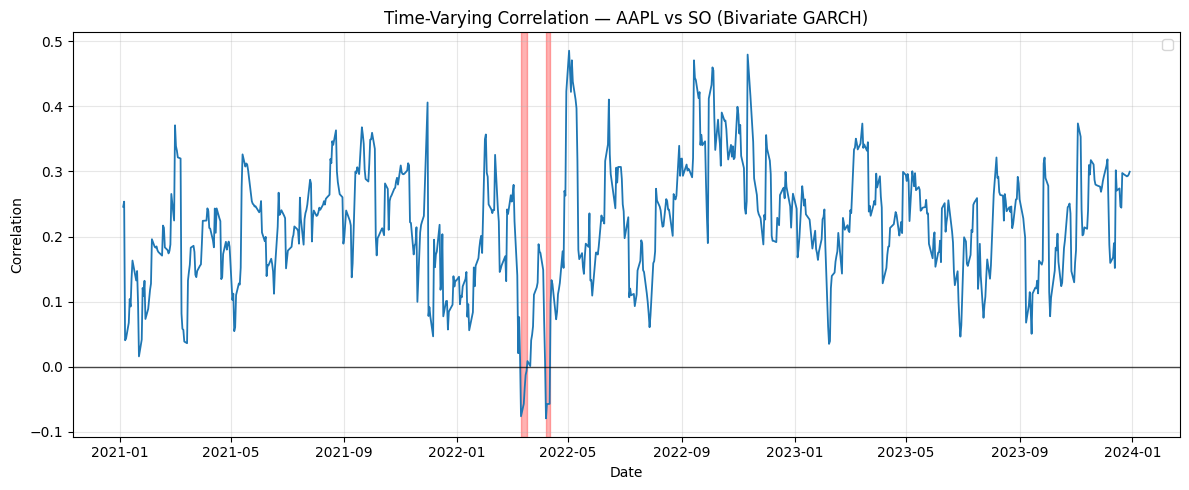

In [40]:
print(f'=' * 60)
print(f'Task 3 - Negative Correlation Analysis')
print(f'=' * 60)
# Your code here

# Data returns for AAPL & SO
df_neg = yf.download(["AAPL","SO"], start="2021-01-01", end="2023-12-31")["Close"].dropna()
df_neg_returns = df_neg.pct_change().dropna()
dates = df_neg_returns.index
x_neg_returns = df_neg_returns["AAPL"]
z_neg_returns = df_neg_returns["SO"]

# Univariate GARCH for each
results = {}
for col in df_return.columns:
    u = df_return[col].to_numpy()
    omega_hat, alpha_hat, beta_hat, var_hat, max_loglike = garch_opt(u)
    results[col] = {
        "omega": omega_hat,
        "alpha": alpha_hat,
        "beta": beta_hat,
        "sigma_L": np.sqrt(omega_hat / (1 - alpha_hat - beta_hat)),
        "var_hat": var_hat,
        "loglike": max_loglike
    }

    print(f"\nGARCH(1,1) MLE Results — {col}")
    print(f"omega  = {omega_hat:.12e}")
    print(f"alpha  = {alpha_hat:.6f}")
    print(f"beta   = {beta_hat:.6f}")
    print(f"Long-run sigma = {results[col]['sigma_L']:.6f}")
    print(f"Max log-likelihood = {max_loglike:.6f}")

x_var = pd.Series(var_x, index=dates)
y_var = pd.Series(var_z, index=dates)

# Bivariate covariance MLE
alpha1, beta1 = 0.10, 0.85
omega1 = max(1e-8, (1 - alpha1 - beta1) * np.cov(x_neg_returns, z_neg_returns, ddof=1)[0, 1])
x1 = np.array([omega1, alpha1, beta1])

res_cov = minimize(
    fun=loglik_cov,
    x0=x1,
    args=(x_neg_returns.to_numpy(), z_neg_returns.to_numpy(), x_var.to_numpy(), y_var.to_numpy()),
    method="trust-constr",
    bounds=[(None, None), (0.0, 0.999999), (0.0, 0.999999)],
    constraints=[{'type': 'ineq', 'fun': lambda x: 0.999999 - x[1] - x[2]}]
)

# MLE Results
omega_c, alpha_c, beta_c = res_cov.x
cov_t = garch_cov((omega_c, alpha_c, beta_c), x_neg_returns.to_numpy(), z_neg_returns.to_numpy())
corr_t = cov_t / np.sqrt(x_var.to_numpy() * y_var.to_numpy())

print("\nBivariate GARCH(1,1) MLE Results — AAPL – SO")
print(f"omega  = {omega_c:.12e}")
print(f"alpha  = {alpha_c:.6f}")
print(f"beta   = {beta_c:.6f}")
print(f"\nStatic Correlation (AAPL, SO) = {np.corrcoef(x_neg_returns, z_neg_returns)[0, 1]:.6f}")
print(f"Average Dynamic Correlation   = {np.nanmean(corr_t):.6f}")

# Visualization
corr_s = pd.Series(corr_t, index=dates)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, corr_s.values, lw=1.3)
ax.axhline(0.0, color="black", lw=1, alpha=0.7)

neg = corr_s < 0
if neg.any():
    starts = neg & ~neg.shift(1, fill_value=False)
    ends   = neg & ~neg.shift(-1, fill_value=False)
    for s, e in zip(corr_s.index[starts], corr_s.index[ends]):
        ax.axvspan(s, e, color="red", alpha=0.3)

ax.set_title("Time-Varying Correlation — AAPL vs SO (Bivariate GARCH)")
ax.set_xlabel("Date"); ax.set_ylabel("Correlation")
ax.grid(alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()
